In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# IO

In [2]:
from PineBioML.preprocessing import IO

In [3]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [4]:
x, y = IO.read_multiple_groups(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

# Train test split

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=142, shuffle=True)

# Experiment

In [6]:
from PineBioML.preprocessing import Normalizer, Pass
from PineBioML.preprocessing.impute import knn_imputer, simple_imputer
from PineBioML.preprocessing.utils import feature_extension
from PineBioML.selection.ensemble import selector
from PineBioML.model.supervised import Classification
from sklearn.linear_model import LogisticRegression


# define the experiment pipeline
experiment = [
    ("MissingValueProcessing", {
        "mean": simple_imputer(threshold=1., strategy="mean")
        }),
    ("Standarization", {
        "PowerTransformer": Normalizer(method="PowerTransformer"), 
        "StandardScaler": Normalizer(method="StandardScaler"),
        }),
    ("FeatureExpansion", {
        "PCA * /": feature_extension(), 
        "None": Pass()
        }),
    ("Selection", {
        "ensemble":selector(RF_trees=256, z_importance_threshold = 1), 
        "None": Pass()
        }),
    ("Modeling", {
        "LgisticRegression": LogisticRegression(penalty = None),
        "ElasticNetLogisticRegression": Classification.ElasticLogit_tuner(target = "roc_auc", validate_penalty=True),
        "rbf-SVM": Classification.SVM_tuner(target="f1", validate_penalty=True),
        "DecisionTree": Classification.DecisionTree_tuner(target="neg_log_loss", validate_penalty=True),
        "RandomForest": Classification.RandomForest_tuner(validate_penalty=True),
        "AdaBoost": Classification.AdaBoost_tuner(target="recall", validate_penalty=True),
        "XGBoost": Classification.XGBoost_tuner(validate_penalty=True),
        "LightGBM": Classification.LighGBM_tuner(validate_penalty=True),
        }),
]

In [7]:
from PineBioML.model.utils import Pine

pine_automl = Pine(experiment)
result = pine_automl.do_experiment(x_train, y_train, x_valid, y_valid)


Using  c45  to select.


100%|██████████| 158/158 [00:00<00:00, 440.04it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    0.2s finished


RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.233e-02, tolerance: 3.350e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.941e-02, tolerance: 3.350e-03
  model = cd_fast.enet_coordinate_descent(


multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7324
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

    optuna is better, best trial:  18
LogisticRegression(C=0.061873055013445755, class_weight='balanced',
                   l1_ratio=0.7825270021085338, penalty='elasticnet',
                   solver='saga') 

optuna seed 71  |  validation seed 6961  |  model seed 16086
    start tuning. it will take a while.
    optuna is better, best trial:  23
SVC(C=158.34873413470524, class_weight='balanced', gamma='auto',
    probability=True, random_state=8485) 

optuna seed 71  |  validation seed 11518  |  model seed 3950
    start tuning. it will take a while.
    optuna is better, best trial:  21
DecisionTreeClassifier(ccp_alpha=0.06995430392280887, class_weight='balanced',
                       max_depth=4, min_samples_split=11, random_state=426) 

optuna seed 71  |  validation seed 7524  |  model seed 15028
    start tuning. it will take a while.
    optuna is better, best trial:  24
RandomForestClassifier(ccp_alpha=0.007757638040232419, class_weight='balanced',
                       max

C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: Unde

optuna seed 71  |  validation seed 14625  |  model seed 7610
    start tuning. it will take a while.
    optuna is better, best trial:  170
LGBMClassifier(class_weight='balanced', learning_rate=0.010042777658280091,
               max_depth=3, min_child_samples=25, n_estimators=32, num_leaves=4,
               random_state=6661, reg_lambda=0.6007555063677047,
               subsample_freq=1, verbosity=-1) 

Using  c45  to select.


100%|██████████| 100/100 [00:00<00:00, 194.64it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    0.4s finished


RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4642
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

    optuna is better, best trial:  11
LogisticRegression(C=0.08251132513486935, class_weight='balanced',
                   l1_ratio=0.998619178844397, penalty='elasticnet',
                   solver='saga') 

optuna seed 71  |  validation seed 6961  |  model seed 16086
    start tuning. it will take a while.
    optuna is better, best trial:  23
SVC(C=200.20758695186146, class_weight='balanced', gamma='auto',
    probability=True, random_state=8485) 

optuna seed 71  |  validation seed 11518  |  model seed 3950
    start tuning. it will take a while.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: Unde

    optuna is better, best trial:  21
DecisionTreeClassifier(ccp_alpha=0.07011005949801337, class_weight='balanced',
                       max_depth=6, min_samples_leaf=2, min_samples_split=13,
                       random_state=426) 

optuna seed 71  |  validation seed 7524  |  model seed 15028
    start tuning. it will take a while.
    optuna is better, best trial:  49
RandomForestClassifier(ccp_alpha=0.009044145660486839, class_weight='balanced',
                       max_depth=14, max_samples=0.7704135143194771,
                       min_samples_leaf=5, n_estimators=292, n_jobs=-1,
                       oob_score=True, random_state=6864) 

optuna seed 71  |  validation seed 4062  |  model seed 15363
    start tuning. it will take a while.
    optuna is better, best trial:  14
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01809899102431482,
                   n_estimators=29, random_state=1376) 

optuna seed 71  |  validation seed 5704  |  model seed 10374
    start tu

100%|██████████| 158/158 [00:00<00:00, 204.24it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    0.4s finished


RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.652e-02, tolerance: 3.350e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.002e-02, tolerance: 3.350e-03
  model = cd_fast.enet_coordinate_descent(


multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7320
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

    optuna is better, best trial:  12
LogisticRegression(C=0.06506794622985379, class_weight='balanced',
                   l1_ratio=0.806112924730366, penalty='elasticnet',
                   solver='saga') 

optuna seed 71  |  validation seed 6961  |  model seed 16086
    start tuning. it will take a while.
    optuna is better, best trial:  23
SVC(C=240.73139798892663, class_weight='balanced', gamma='auto',
    probability=True, random_state=8485) 

optuna seed 71  |  validation seed 11518  |  model seed 3950
    start tuning. it will take a while.
    optuna is better, best trial:  21
DecisionTreeClassifier(ccp_alpha=0.06995430392280887, class_weight='balanced',
                       max_depth=4, min_samples_split=11, random_state=426) 

optuna seed 71  |  validation seed 7524  |  model seed 15028
    start tuning. it will take a while.
    optuna is better, best trial:  37
RandomForestClassifier(ccp_alpha=0.014265930139097917, class_weight='balanced',
                       max_d

100%|██████████| 100/100 [00:00<00:00, 202.39it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    0.8s finished


RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4640
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

    optuna is better, best trial:  11
LogisticRegression(C=0.08251132513486935, class_weight='balanced',
                   l1_ratio=0.998619178844397, penalty='elasticnet',
                   solver='saga') 

optuna seed 71  |  validation seed 6961  |  model seed 16086
    start tuning. it will take a while.
    optuna is better, best trial:  23
SVC(C=137.11886709323161, class_weight='balanced', gamma='auto',
    probability=True, random_state=8485) 



C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1471: Unde

optuna seed 71  |  validation seed 11518  |  model seed 3950
    start tuning. it will take a while.
    optuna is better, best trial:  21
DecisionTreeClassifier(ccp_alpha=0.07011005949801337, class_weight='balanced',
                       max_depth=6, min_samples_leaf=2, min_samples_split=13,
                       random_state=426) 

optuna seed 71  |  validation seed 7524  |  model seed 15028
    start tuning. it will take a while.
    optuna is better, best trial:  49
RandomForestClassifier(ccp_alpha=0.009044145660486839, class_weight='balanced',
                       max_depth=14, max_samples=0.7704135143194771,
                       min_samples_leaf=5, n_estimators=292, n_jobs=-1,
                       oob_score=True, random_state=6864) 

optuna seed 71  |  validation seed 4062  |  model seed 15363
    start tuning. it will take a while.
    optuna is better, best trial:  14
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01809899102431482,
                   n_estimato

In [8]:
# print the results
result

,MissingValueProcessing,Standarization,FeatureExpansion,Selection,Modeling,train_precision,train_recall,train_f1-score,train_support,train_sensitivity,...,cv_mcc,cv_auc,test_precision,test_recall,test_f1-score,test_support,test_sensitivity,test_specificity,test_mcc,test_auc
0,mean,PowerTransformer,PCA * /,ensemble,LgisticRegression,0.710145,0.731343,0.720588,67.0,0.731343,...,0.385680,0.751479,0.627907,0.818182,0.710526,33.0,0.818182,0.515152,0.349780,0.718090
1,mean,PowerTransformer,PCA * /,ensemble,ElasticNetLogisticRegression,0.710145,0.731343,0.720588,67.0,0.731343,...,0.385680,0.750380,0.627907,0.818182,0.710526,33.0,0.818182,0.515152,0.349780,0.718090
2,mean,PowerTransformer,PCA * /,ensemble,rbf-SVM,0.737705,0.671642,0.703125,67.0,0.671642,...,0.319484,0.754269,0.600000,0.727273,0.657534,33.0,0.727273,0.515152,0.248069,0.641873
3,mean,PowerTransformer,PCA * /,ensemble,DecisionTree,0.622449,0.910448,0.739394,67.0,0.910448,...,0.208855,0.608791,0.645833,0.939394,0.765432,33.0,0.939394,0.484848,0.476290,0.712121
4,mean,PowerTransformer,PCA * /,ensemble,RandomForest,0.762712,0.671642,0.714286,67.0,0.671642,...,0.393780,0.731023,0.621622,0.696970,0.657143,33.0,0.696970,0.575758,0.274753,0.722681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,mean,StandardScaler,None,None,DecisionTree,0.622449,0.910448,0.739394,67.0,0.910448,...,0.288859,0.621429,0.645833,0.939394,0.765432,33.0,0.939394,0.484848,0.476290,0.712121
60,mean,StandardScaler,None,None,RandomForest,1.000000,1.000000,1.000000,67.0,1.000000,...,0.221145,0.557819,0.605263,0.696970,0.647887,33.0,0.696970,0.545455,0.245256,0.685950
61,mean,StandardScaler,None,None,AdaBoost,0.589286,0.985075,0.737430,67.0,0.985075,...,0.310246,0.636264,0.581818,0.969697,0.727273,33.0,0.969697,0.303030,0.365902,0.713499
62,mean,StandardScaler,None,None,XGBoost,0.622449,0.910448,0.739394,67.0,0.910448,...,0.316139,0.662637,0.645833,0.939394,0.765432,33.0,0.939394,0.484848,0.476290,0.682277


In [9]:
# sort according to test_auc
result.sort_values("test_auc")

,MissingValueProcessing,Standarization,FeatureExpansion,Selection,Modeling,train_precision,train_recall,train_f1-score,train_support,train_sensitivity,...,cv_mcc,cv_auc,test_precision,test_recall,test_f1-score,test_support,test_sensitivity,test_specificity,test_mcc,test_auc
44,mean,StandardScaler,PCA * /,None,RandomForest,0.970588,0.985075,0.977778,67.0,0.985075,...,-0.016085,0.506509,0.621622,0.696970,0.657143,33.0,0.696970,0.575758,0.274753,0.564738
42,mean,StandardScaler,PCA * /,None,rbf-SVM,1.000000,1.000000,1.000000,67.0,1.000000,...,0.097306,0.547591,0.478261,0.333333,0.392857,33.0,0.333333,0.636364,0.121716,0.619835
10,mean,PowerTransformer,PCA * /,None,rbf-SVM,1.000000,1.000000,1.000000,67.0,1.000000,...,0.125363,0.546238,0.541667,0.393939,0.456140,33.0,0.393939,0.666667,0.121716,0.624426
26,mean,PowerTransformer,None,None,rbf-SVM,1.000000,1.000000,1.000000,67.0,1.000000,...,0.092098,0.576162,0.520000,0.393939,0.448276,33.0,0.393939,0.636364,0.181902,0.629017
58,mean,StandardScaler,None,None,rbf-SVM,1.000000,1.000000,1.000000,67.0,1.000000,...,0.092098,0.569569,0.586207,0.515152,0.548387,33.0,0.515152,0.636364,0.151515,0.629017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,mean,PowerTransformer,PCA * /,None,RandomForest,0.928571,0.970149,0.948905,67.0,0.970149,...,0.157018,0.626881,0.710526,0.818182,0.760563,33.0,0.818182,0.666667,0.490511,0.750230
9,mean,PowerTransformer,PCA * /,None,ElasticNetLogisticRegression,0.656716,0.656716,0.656716,67.0,0.656716,...,0.299361,0.711074,0.710526,0.818182,0.760563,33.0,0.818182,0.666667,0.490511,0.796143
41,mean,StandardScaler,PCA * /,None,ElasticNetLogisticRegression,0.661972,0.701493,0.681159,67.0,0.701493,...,0.258858,0.690110,0.717949,0.848485,0.777778,33.0,0.848485,0.666667,0.523884,0.796143
25,mean,PowerTransformer,None,None,ElasticNetLogisticRegression,0.657143,0.686567,0.671533,67.0,0.686567,...,0.251696,0.707439,0.692308,0.818182,0.750000,33.0,0.818182,0.636364,0.462250,0.797062


In [10]:
# save the result
result.to_csv("./output/example_Pine_result.csv")

# Pick a model and save it

In [11]:
# notice that the model is not fitted yet
model = pine_automl.recall_model(id = 9)

In [12]:
# fit the model
model.fit(x_train, y_train)
y_valid_prob = model.predict_proba(x_valid)[:,1]

optuna seed 71  |  validation seed 13694  |  model seed 7398
    start tuning. it will take a while.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

    optuna is better, best trial:  18
LogisticRegression(C=0.061873055013445755, class_weight='balanced',
                   l1_ratio=0.7825270021085338, penalty='elasticnet',
                   solver='saga') 



C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

### summary


 
              precision    recall  f1-score   support

         0.0       0.79      0.67      0.72        33
         1.0       0.71      0.82      0.76        33

    accuracy                           0.74        66
   macro avg       0.75      0.74      0.74        66
weighted avg       0.75      0.74      0.74        66

sensitivity: 0.818
specificity: 0.667


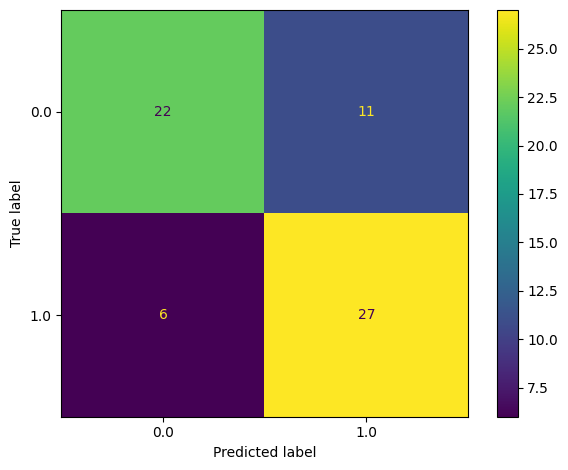

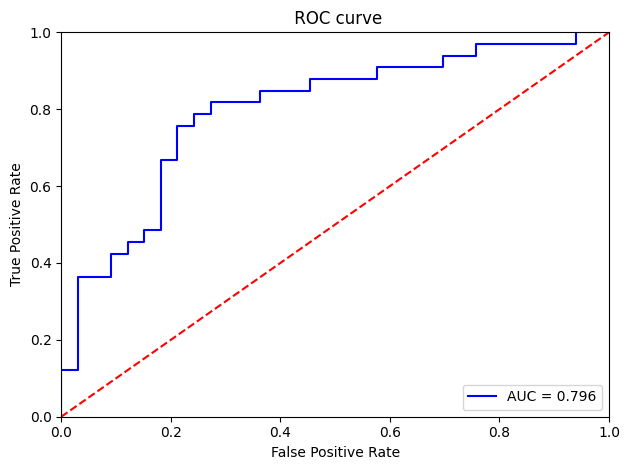

In [13]:
from PineBioML.report.utils import classification_summary

classification_summary(y_valid, y_valid_prob)

### save the model

In [14]:
from PineBioML import IO

In [15]:
IO.save_model(model, "./output/models/", "model9", overide=True)